In [36]:
%matplotlib ipympl

from experimental.beacon_sim.experiment_results_pb2 import ExperimentResult
from experimental.beacon_sim.world_map_config_pb2 import WorldMapConfig
from experimental.beacon_sim.mapped_landmarks_pb2 import MappedLandmarks
import planning.probabilistic_road_map_python as prmp

import pandas as pd
import pandas.io.formats.style

from collections import defaultdict
import matplotlib.pyplot as plt
from IPython.display import display
import ipywidgets
import matplotlib as mpl
import re

mpl.style.use('ggplot')

import seaborn as sns

from pathlib import Path

mpl.style.use('ggplot')

import seaborn as sns

from pathlib import Path

import numpy as np

import experimental.beacon_sim.ekf_slam_python as esp
import experimental.beacon_sim.belief_road_map_planner_python as brmp
import experimental.beacon_sim.beacon_potential_python as bpp
import planning.probabilistic_road_map_python as prmp
import common.time.robot_time_python as rtp
import experimental.beacon_sim.robot_belief_python as rbp
import common.liegroups.se2_python as se2


In [ ]:
METRIC_NAME = 'prob_mass_in_region_regret'

In [37]:
# file_name = '/tmp/compare_against_baseline_complex_env.pb'
# file_name = '/tmp/test_timing.pb'
results_dir = Path('/home/rrg/Desktop/david_results/')
configs_dir = Path('/home/rrg/Desktop/david_results/Test_2_visits_and_paths_param/Test_2_pb_files/')
results_files = sorted(results_dir.glob("*.pb"))
# file_name = "/home/erick/scratch/beacon_sim/results/spatial_clus_dens_5.0E-04_p_beacon_0.75_p_no_beacon_0.50_lm_density_1.00E-01.pb"
protos_by_exp = {}
configs_by_exp = {}

for f in results_files:
    with open(f, 'rb') as file_in:
        data = ExperimentResult()
        data.ParseFromString(file_in.read())
        protos_by_exp[f.stem] = data

        map_config_path = configs_dir / f.stem / data.experiment_config.map_config_path
        road_map_path = configs_dir / f.stem / data.experiment_config.road_map_path
        mapped_landmark_path = configs_dir / f.stem / data.experiment_config.ekf_state_path

        wmc = WorldMapConfig()
        wmc.ParseFromString(map_config_path.read_bytes())

        assert road_map_path.exists()
        map_proto = MappedLandmarks()
        map_proto.ParseFromString(mapped_landmark_path.read_bytes())
        configs_by_exp[f.stem] = {
            'road_map': prmp.RoadMap.from_proto_string(road_map_path.read_bytes()),
            'world_map_config': wmc,
            'mapped_landmarks': map_proto,
        }

        

In [38]:
def protobuf_to_df(pb):
    out = defaultdict(list)
    i = 0

    for result in pb.results:
        planner_name = pb.planner_names[result.planner_id]
        if planner_name.startswith('David'):
            m = re.match(r"^David Planner (FG)-(\d+\.\d+) (MV)-(\d+) (P)-(\d+)",planner_name)
            out['planner_type'].append('David')
            out['planner_size'].append(None)
            out['favor_goal'].append(m.group(2))
            out['max_visits'].append(m.group(4))
            out['plans'].append(m.group(6))
        else:
            m = re.match(r'(.*?) BRM\s?(\d*)', planner_name)
            out['planner_type'].append(m.group(1))
            out['planner_size'].append(m.group(2) if len(m.group(2)) > 0 else '1')
            out['favor_goal'].append(None)
            out['max_visits'].append(None)
            out['plans'].append(None)
        
        out['elapsed_time'].append(result.elapsed_time.count / 1e9)
        out['trial_id'].append(result.trial_id)
        out['planner_id'].append(result.planner_id)
        out['planner_name'].append(planner_name)
        out['start'].append(np.array(pb.start_goal[result.trial_id].start.data))
        out['goal'].append(np.array(pb.start_goal[result.trial_id].goal.data))
        out['timeout'].append(pb.experiment_config.plan_timeout_s)
        if result.HasField('plan'):
            out['plan'].append(list(result.plan.nodes))
            out['log_prob_mass'].append(result.plan.log_prob_mass)
            out['expected_size'].append(result.plan.expected_size)
            out['expected_determinant'].append(result.plan.average_plan_metrics.expected_determinant)
            out['expected_position_determinant'].append(result.plan.average_plan_metrics.expected_position_determinant)
            out['prob_mass_in_region'].append(1-result.plan.average_plan_metrics.prob_mass_in_region)
            out['prob_mass_in_region_regret'].append(-result.plan.average_plan_metrics.prob_mass_in_region_regret)
        else:
            out['plan'].append(None)
            out['log_prob_mass'].append(None)
            out['expected_size'].append(None)
            out['expected_determinant'].append(None)
            out['expected_position_determinant'].append(None)
            out['prob_mass_in_region'].append(None)
            out['prob_mass_in_region_regret'].append(None)
    return pd.DataFrame(out)


def extract_clusters_from_potential(potential_proto):
    
    potential_case = potential_proto.WhichOneof('potential_oneof')
    if potential_case in ['correlated_beacon_potential', 'anticorrelated_potential', 'precision_matrix_potential']:
        return [list(getattr(potential_proto, potential_case).members)]  
    elif potential_case == 'combined_potential':
        out = []
        for pot in potential_proto.combined_potential.potentials:
            out.extend(extract_clusters_from_potential(pot))
        return out
    print('unknown potential type', potential_case)
    raise NotImplementedError
    ...

def plot_mapped_landmarks(mapped_landmarks, potential_proto):
    # extract clusters from potential
    clusters = extract_clusters_from_potential(potential_proto)
    
    ids = list(mapped_landmarks.beacon_ids)
    for cluster in clusters:
        xs = []
        ys = []
        for beacon_id in cluster:
            idx = ids.index(beacon_id)
            beacon_in_map = mapped_landmarks.beacon_in_local[idx]
            xs.append(beacon_in_map.data[0])
            ys.append(beacon_in_map.data[1])
            # plt.text(beacon_in_map.data[0], beacon_in_map.data[1], f't_{ids[i]}')
        plt.plot(xs, ys, 'o')

def plot_road_map(road_map):
    pts = np.stack(road_map.points())
    plt.plot(pts[:, 0], pts[:, 1], '*')
    for i, pt in enumerate(pts):
        plt.text(*pt, str(i))

    if road_map.has_start_goal():
        for idx, marker in [(road_map.START_IDX, 'rs'), (road_map.GOAL_IDX, 'y*')]:
            pt = road_map.point(idx)
            plt.plot(*pt, marker)
            

    line_segments = []
    for i in range(len(pts)):
        for j in range(i+1, len(pts)):
            if road_map.adj()[i, j] != 0:
                line_segments.append([pts[i, :], pts[j,:]])

    if road_map.has_start_goal():
        for idx in [road_map.START_IDX, road_map.GOAL_IDX]:
            pt = road_map.point(idx)
            neighbors = road_map.neighbors(idx)
            for _, neighbor_pt in neighbors:
                line_segments.append([pt, neighbor_pt])
    

    edges = mpl.collections.LineCollection(line_segments, colors=(0.6, 0.8, 0.6, 1.0))
    ax = plt.gca()
    ax.add_collection(edges)

def plot_plan(road_map, execution_df):
    pts = [execution_df['start'].iloc[0]]
    pts += [road_map.point(x) for x in execution_df.plan.iloc[0] if x >=0]
    pts.append(execution_df['goal'].iloc[0])
    pts = np.vstack(pts)

    plt.plot(pts[:, 0], pts[:, 1], 'm')
    plt.plot(pts[0, 0], pts[0, 1], 'gs')
    plt.plot(pts[-1, 0], pts[-1, 1], 'rv')
    ...

    


In [39]:
sub_dfs = []
for name, proto in protos_by_exp.items():
    sub_df = protobuf_to_df(proto)
    sub_df['exp_name'] = name
    sub_df['exp_type'] = name.split('_')[0]
    sub_dfs.append(sub_df)
df = pd.concat(sub_dfs)
df.reset_index(inplace=True)

ValueError: No objects to concatenate

In [40]:
df

NameError: name 'df' is not defined

In [41]:
def make_plots(df, cdf_fig, pdf_fig, exec_time_fig):
    bins = np.linspace(0, 3, 1000)
    plt.figure(cdf_fig)
    plt.subplot(121)
    plt.cla()
    for i, g in df.groupby('planner_id'):
        plt.hist(g['expected_det'], density=True, histtype='step', label=g['planner_name'].iloc[0], bins=bins, cumulative=True)
        
    plt.xlabel('Expected Determinant')
    plt.ylabel('Fraction')
    plt.legend()
    plt.suptitle(df["exp_name"].iloc[0])
    plt.tight_layout()
    

    plt.figure(pdf_fig)
    ax = plt.gca()
    plt.cla()
    axes = df.plot.hist(by='planner_name', column='expected_det', bins=50, ax=ax)
    axes[-1].set_xlabel('Expected Determinant')
    plt.suptitle('Expected Determinant')
    plt.tight_layout()
    
    plt.figure(exec_time_fig)
    ax = plt.gca()
    plt.cla()
    axes = df.plot.hist(by='planner_name', column='elapsed_time', bins=50, ax=ax)
    for i, ax in enumerate(axes):
        ax.set_yscale('log')

    axes[-1].set_xlabel('Elapsed Time (s)')
    plt.suptitle('Elasped Time')
    plt.tight_layout()

def make_trial_plot(trial_fig, trial_df):
    plt.figure(trial_fig)
    plt.subplot(122)
    plt.cla()
    exp_name = trial_df['exp_name'].iloc[0]
    exp_configs = configs_by_exp[exp_name]
    plot_mapped_landmarks(exp_configs['mapped_landmarks'], exp_configs['world_map_config'].correlated_beacons.potential)
    plot_road_map(exp_configs['road_map'])
    plot_plan(exp_configs['road_map'], trial_df)


def plot_overview_results(df):
    exps = np.unique(df['exp_name'])
    exp_selector = ipywidgets.Dropdown(options=exps, description='experiment:')
    trial_selector = ipywidgets.IntSlider(min=0, max=1, step=1, value=0, description='Trial Selector:', behavior='snap')
    planner_selector = ipywidgets.Dropdown(options=[], description='planner:')
    hbox = ipywidgets.HBox()
    cdf_fig = plt.figure(figsize=(16, 8))
    pdf_fig = plt.figure(figsize=(13,10))
    exec_time_fig = plt.figure(figsize=(13,10))
    # trial_fig = plt.figure(figsize=(8, 8))

    def on_trial_or_planner_change(change):
        exp_mask = df['exp_name'] == exp_selector.value
        trial_mask = df['trial_id'] == trial_selector.value
        planner_mask = df['planner_name'] == planner_selector.value
        mask = exp_mask & trial_mask
        execution_mask = mask & planner_mask

        trial_df = df[mask]
        #_ = display(trial_df, display_id='trial_df')
        execution_df = df[execution_mask]
        make_trial_plot(cdf_fig, execution_df)

        
    def on_instance_change(change):
        selected_exp_name = exp_selector.value
         
        sub_df = df[df['exp_name'] == selected_exp_name]

        trial_selector.min = 0
        trial_selector.max = sub_df['trial_id'].max()
        trial_selector.value = 0

        planner_selector.options = np.unique(sub_df['planner_name'])
        planner_selector.value = planner_selector.options[0]
        
        make_plots(sub_df, cdf_fig, pdf_fig, exec_time_fig)
        on_trial_or_planner_change({})

        
    
    hbox.children=(exp_selector, trial_selector, planner_selector)

    exp_selector.observe(on_instance_change, 'value')
    trial_selector.observe(on_trial_or_planner_change, 'value')
    planner_selector.observe(on_trial_or_planner_change, 'value')
    display(hbox)
    on_instance_change({})
    
   

In [42]:
plot_overview_results(df)


# axes = df.plot.hist(by='planner_id', column='log_prob_mass', bins=50, figsize=(13,10))
# for i, ax in enumerate(axes):
#     ax.set_yscale('log')
#     ax.set_title(planners[i])
# axes[-1].set_xlabel('Log Prob Mass')
# plt.suptitle('Log Prob Mass')
# plt.tight_layout()

NameError: name 'df' is not defined

NameError: name 'df' is not defined

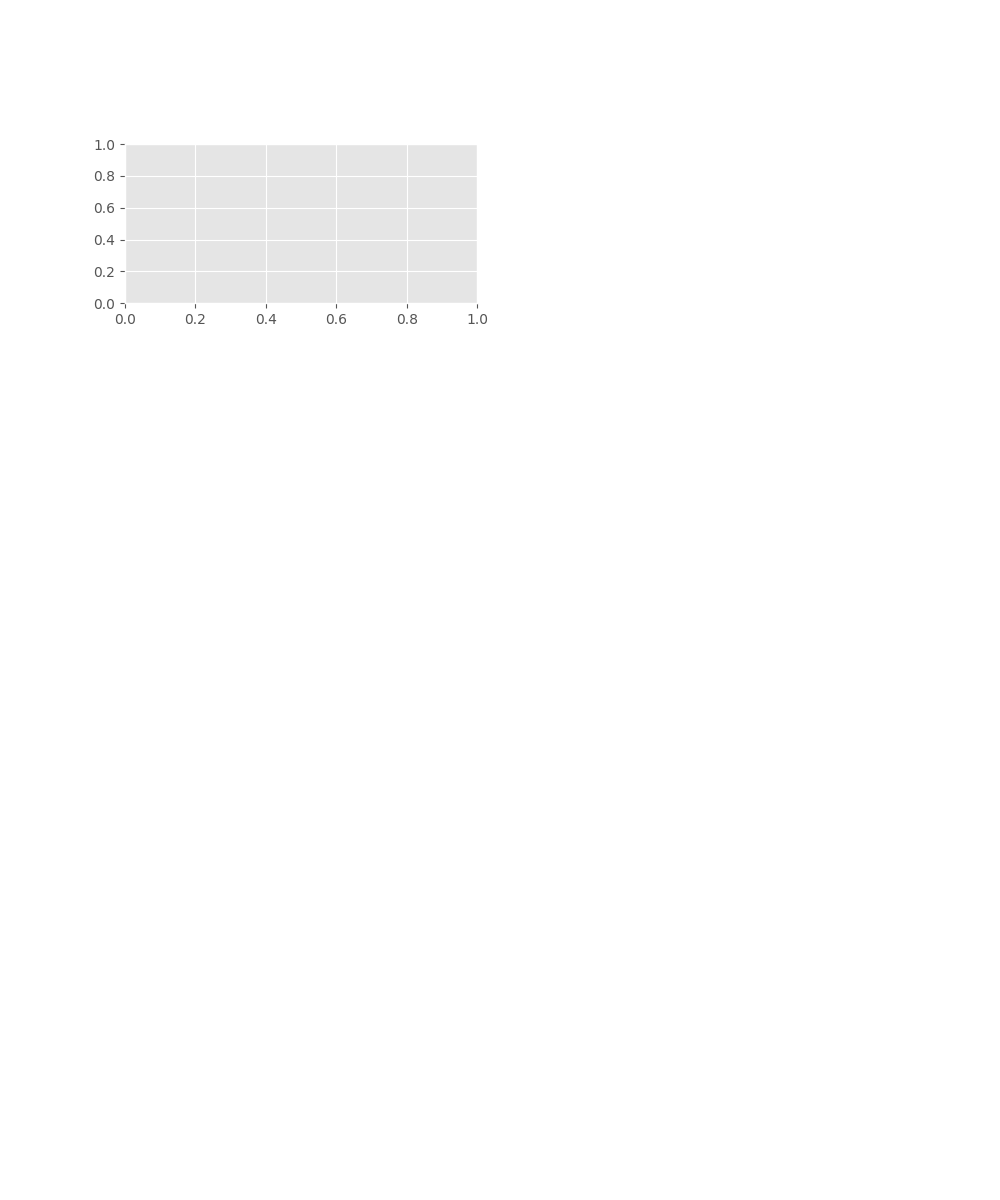

In [43]:
def make_summary_plots(exps_and_locs, num_rows, num_cols, sup_title, timeout=None, to_remove=None, fig_path=None):
    if to_remove is None:
        to_remove = []

    if timeout:
        to_remove.append(f'_timeout_{timeout:02d}')
        sup_title = f"{sup_title}_timeout_{timeout:04d}"
        
    
    for exp_name, plot_id in exps_and_locs:
        if timeout:
            exp_name = f"{exp_name}_timeout_{timeout:02d}"
        plt.subplot(num_rows, num_cols, plot_id)
        exp_mask = df['exp_name'] == exp_name
        exp_df = df[exp_mask]
        if not exp_df.empty:
            ax = sns.boxplot(x='planner_type',
                        y='expected_det',
                        hue='favor_goal',#I assume I add something here?
                        data=exp_df,
                       legend=(plot_id==1))
                
            if plot_id == 1:
                sns.move_legend(ax, 'upper left', bbox_to_anchor=(0.1, 1.0))
        
        plot_title = exp_name
        for r in to_remove:
            plot_title = plot_title.replace(r, '')
            
        plt.title(plot_title)
        plt.xlabel('')
        #plt.ylim(0, 3)

        
    plt.suptitle(sup_title)
    plt.tight_layout()
    if fig_path:
        plt.savefig(fig_path / f"summary_{sup_title}.svg")

    ...

timeouts = [60]

fig_path = None

for timeout in timeouts:
    indep_exps_and_locs = [
        ('indep_p_beacon_0.25_lm_density_1.0E-02', 1),
        ('indep_p_beacon_0.50_lm_density_1.0E-02', 2),
        ('indep_p_beacon_0.75_lm_density_1.0E-02', 3),
        ('indep_p_beacon_1.00_lm_density_1.0E-02', 4),
    ]
    
    plt.figure(figsize=(10,12))
    make_summary_plots(indep_exps_and_locs, num_rows=5, num_cols=2, sup_title='indep', timeout=timeout, fig_path=fig_path, to_remove=['indep_'])
        

# for i, exp_df in df.groupby('exp_name'):
#     plt.figure()
#     sns.boxplot(x='planner_type',
#                 y='expected_det',
#                 hue='planner_size',
#                 data=exp_df)
#     # exp_df.boxplot(column='expected_det', by=['planner_name'], rot=90)
#     plt.title(exp_df['exp_name'].iloc[0])
    # plt.tight_layout()

In [44]:
wmc = configs_by_exp['mutex_num_class_2_lm_density_1.00E-02']['world_map_config']

KeyError: 'mutex_num_class_2_lm_density_1.00E-02'

In [45]:
potential = wmc.correlated_beacons.potential

NameError: name 'wmc' is not defined

In [46]:
fig_dir = Path('/home/erick/scratch/beacon_sim/20240604/figs')
fig_dir.mkdir(exist_ok=True)

for _, exp_df in df.groupby('exp_name'):
    exp_name = exp_df['exp_name'].iloc[0]
    fig = plt.figure(figsize=(25.6, 9.6))
    plt.subplot(121)
    bins = np.linspace(0, 3, 1000)
    for i, g in exp_df.groupby('planner_id'):
        plt.hist(g['expected_det'], density=True, histtype='step', label=g['planner_name'].iloc[0], bins=bins, cumulative=True)
        
    plt.xlabel('Expected Determinant')
    plt.ylabel('Fraction')
    plt.legend()
    plt.suptitle(exp_name)

    plt.subplot(122)
    exp_configs = configs_by_exp[exp_name]
    plot_mapped_landmarks(exp_configs['mapped_landmarks'], exp_configs['world_map_config'].correlated_beacons.potential)
    plot_road_map(exp_configs['road_map'])
    plt.xlabel('X (m)')
    plt.ylabel('Y (m)')
    plt.tight_layout()
    plt.savefig(fig_dir / (exp_name + '.svg'))
    plt.close(fig)
    

FileNotFoundError: [Errno 2] No such file or directory: '/home/erick/scratch/beacon_sim/20240604/figs'

In [47]:
### exp_df.exp_name[0]

In [48]:
fig.get_size_inches()

array([12.,  6.])

In [49]:
getattr?

Docstring:
getattr(object, name[, default]) -> value

Get a named attribute from an object; getattr(x, 'y') is equivalent to x.y.
When a default argument is given, it is returned when the attribute doesn't
exist; without it, an exception is raised in that case.
Type:      builtin_function_or_method

In [50]:
mpl.__version__

'3.6.2'

KeyError: 'spatial_clus_dens_1.0E-03_p_beacon_0.50_p_no_beacon_0.50_lm_density_1.00E-01_timeout_30'

/home/rrg/.cache/bazel/_bazel_rrg/c57e5cced278a73ae4b24e90b22a7669/execroot/robot/bazel-out/k8-fastbuild/bin/common/python/jupyter_notebook.runfiles/pip_3_10_ipympl/site-packages/ipympl/backend_nbagg.py:336: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  self.figure.savefig(buf, format='png', dpi='figure')


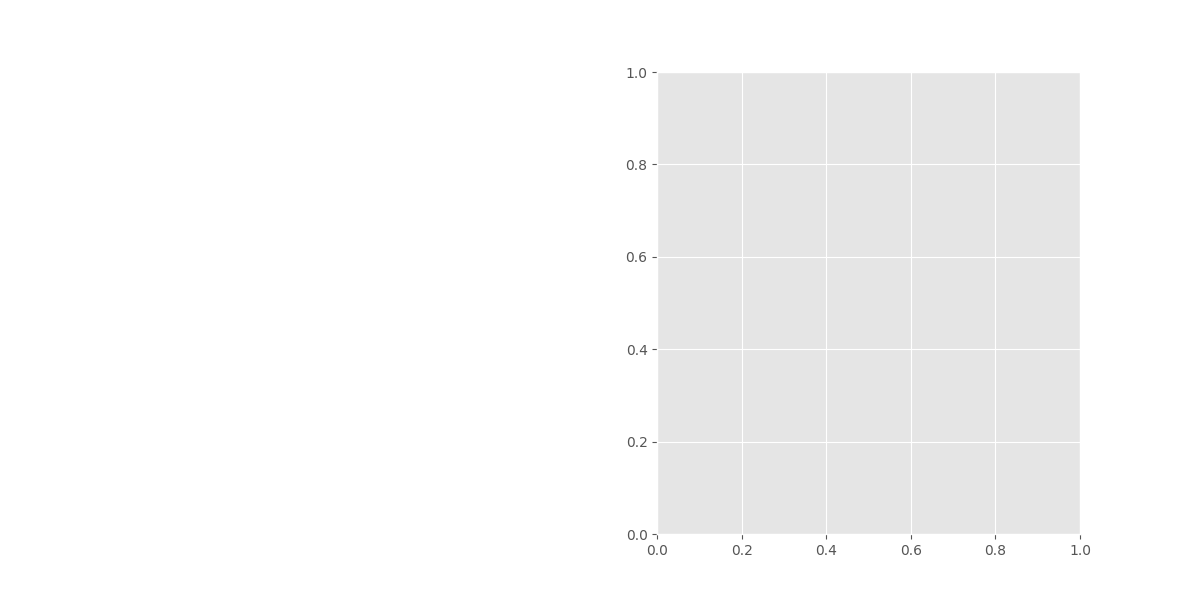

In [51]:
exp_name_template = 'spatial_clus_dens_1.0E-03_p_beacon_0.50_p_no_beacon_0.50_lm_density_1.00E-01_timeout_{:02d}'

fig =  plt.figure(constrained_layout=True, figsize=(12,6))
gs = mpl.gridspec.GridSpec(3, 2)
ax = fig.add_subplot(gs[:, 1])
exp_configs = configs_by_exp[exp_name_template.format(30)]
plot_mapped_landmarks(exp_configs['mapped_landmarks'], exp_configs['world_map_config'].correlated_beacons.potential)
plot_road_map(exp_configs['road_map'])
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
# plot_plan(exp_configs['road_map'], trial_df)

for plot_id, timeout in enumerate([30, 60, 3600]):
    ax = fig.add_subplot(gs[plot_id, 0])
    
    exp_name = exp_name_template.format(timeout)
    mask = df['exp_name'] == exp_name
    exp_df = df[mask]
    sns.boxplot(x='planner_type',
                        y='expected_det',
                        hue='planner_size',
                        data=exp_df,
                       legend=(plot_id==0))

    plt.xlabel('')
    plt.title(f'{timeout:02d} s timeout')
    if plot_id == 0:
        sns.move_legend(ax, 'upper left', bbox_to_anchor=(0.1, 1.0))
    plt.ylim(0, 1.25)

plt.suptitle('Landmark Clusters P(Beacon Present)=0.5 P(Beacon | Beacon Present) = 0.5')

plt.tight_layout()


KeyError: 'mutex_num_class_4_lm_density_1.00E-02_timeout_30'

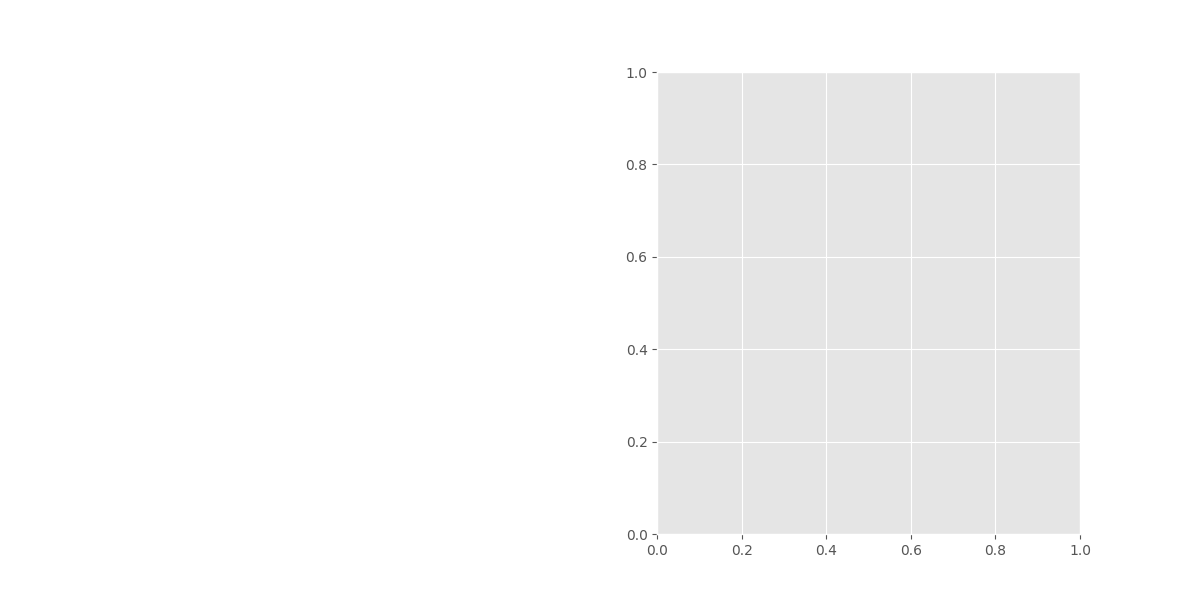

In [52]:
exp_name_template = 'mutex_num_class_4_lm_density_1.00E-02_timeout_{:02d}'

fig =  plt.figure(constrained_layout=True, figsize=(12,6))
gs = mpl.gridspec.GridSpec(3, 2)
ax = fig.add_subplot(gs[:, 1])
exp_configs = configs_by_exp[exp_name_template.format(30)]
plot_mapped_landmarks(exp_configs['mapped_landmarks'], exp_configs['world_map_config'].correlated_beacons.potential)
plot_road_map(exp_configs['road_map'])
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
# plot_plan(exp_configs['road_map'], trial_df)

for plot_id, timeout in enumerate([60]):
    ax = fig.add_subplot(gs[plot_id, 0])
    
    exp_name = exp_name_template.format(timeout)
    mask = df['exp_name'] == exp_name
    exp_df = df[mask]
    sns.boxplot(x='planner_type',
                        y='expected_det',
                        hue='planner_size',
                        data=exp_df,
                       legend=(plot_id==0))

    plt.xlabel('')
    plt.title(f'{timeout:02d} s timeout')
    if plot_id == 0:
        sns.move_legend(ax, 'upper left', bbox_to_anchor=(0.1, 1.0))
    plt.ylim(0, 1.25)
    
plt.suptitle('Mutal Exclusion 4 Classes')
plt.tight_layout()


In [53]:
summary_statistics = {}
for keys, sub_df in df.groupby(by=['exp_type', 'planner_type', 'favor_goal', 'max_visits', 'plans', 'timeout']):
    # display(sub_df)
    summary_statistics[keys] = {
        r'$p_{25}(E[|\Sigma|])$': sub_df['expected_det'].quantile(0.25),
        r'$p_{50}(E[|\Sigma|])$': sub_df['expected_det'].quantile(0.5),
        r'$p_{75}(E[|\Sigma|])$': sub_df['expected_det'].quantile(0.75),
        r'$p_{50}(T_{plan})$': sub_df['elapsed_time'].quantile(0.50),
        r'$p_{95}(T_{plan})$': sub_df['elapsed_time'].quantile(0.95),
    }

summary_statistics = pd.DataFrame(summary_statistics).transpose()
summary_statistics.index.set_names(['Environment', 'Planner', 'Size', 'Timeout'], inplace=True)



NameError: name 'df' is not defined

In [54]:
styler = pd.io.formats.style.Styler(summary_statistics.loc[:, :, :, 60.0])

AttributeError: 'dict' object has no attribute 'loc'

In [55]:
def exp_det_formatter(value):
    if value < 0.01:
        return f"{value:0.2e}"
    else:
        return f"{value:0.3f}"

def index_formatter(value):
    # print(f"'{value}'")
    if value == 'Expected':
        return 'BRULE-E'
    elif value == 'Landmark':
        return "BRULE"
    elif value == 'indep':
        return "Indep."
    elif value == 'mutex':
        return "Mutex"
    elif value == 'semantic':
        return 'Semantic'
    elif value == 'spatial':
        return 'Spatial'
    
    return value

styler.format(subset=[ r'$p_{25}(E[|\Sigma|])$',  r'$p_{50}(E[|\Sigma|])$',  r'$p_{75}(E[|\Sigma|])$'], formatter=exp_det_formatter)
styler.format(subset=[r'$p_{50}(T_{plan})$', r'$p_{95}(T_{plan})$'], precision=3)
styler.format_index(formatter=index_formatter)

NameError: name 'styler' is not defined

In [56]:
print(styler.to_latex(clines="skip-last;data", hrules=True, column_format='lll|rrr|rr'))

NameError: name 'styler' is not defined